## Load Libraries

Load Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sqlite3
import string

## Impor Dataset

In [2]:
df = pd.read_csv('train_preprocess.tsv',sep='\t',names=['Tweet','Label'])
df.head()

Tweet     Label
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1  mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2  lokasi strategis di jalan sumatera bandung . t...  positive
3  betapa bahagia nya diri ini saat unboxing pake...  positive
4  duh . jadi mahasiswa jangan sombong dong . kas...  negative

In [3]:
df.shape

(11000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   11000 non-null  object
 1   Label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


## i. Missing Value

In [5]:
# Cek Missing Value

df.isna().sum()

Tweet    0
Label    0
dtype: int64

In [6]:
# Cek Data Duplikat

print('Data Duplikat: {}'.format(df.duplicated().sum()))

Data Duplikat: 67


In [7]:
# Hapus Data Duplikat

df = df.drop_duplicates()
print('Data Duplikat: {}'.format(df.duplicated().sum()))
print('Data duplikat berhasil dihapus')

Data Duplikat: 0
Data duplikat berhasil dihapus


In [8]:
# Cek jumlah baris dan kolom

df.shape

(10933, 2)

### Hasil Data Preprocessing
- Tidak ada data yang kosong, maka tidak perlu missing value
- Terdapat 67 data duplikat pada dataset dan berhasil dihapus (Tersisa 10933 data)

## ii. Exploratory Data Analysis 

Cek Label dan Distribusi "total_word"

In [9]:
# Distribusi berdasarkan label

df.Label.value_counts()

positive    6383
negative    3412
neutral     1138
Name: Label, dtype: int64

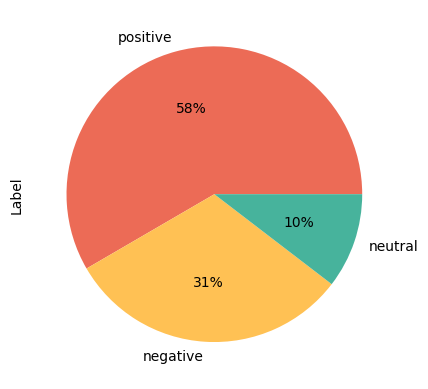

In [10]:
# Visualisasi pie chart

df.Label.value_counts().plot.pie(autopct='%1.0f%%', colors = ['#EC6B56','#FFC154','#47B39C'])
plt.show()

In [11]:
# Buat Kolom baru "total_kata"

df['total_kata'] = df["Tweet"].apply(lambda word: len(word.split()))
df.head()

Tweet     Label  total_kata
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive          66
1  mohon ulama lurus dan k212 mmbri hujjah partai...   neutral          17
2  lokasi strategis di jalan sumatera bandung . t...  positive          33
3  betapa bahagia nya diri ini saat unboxing pake...  positive          17
4  duh . jadi mahasiswa jangan sombong dong . kas...  negative          38

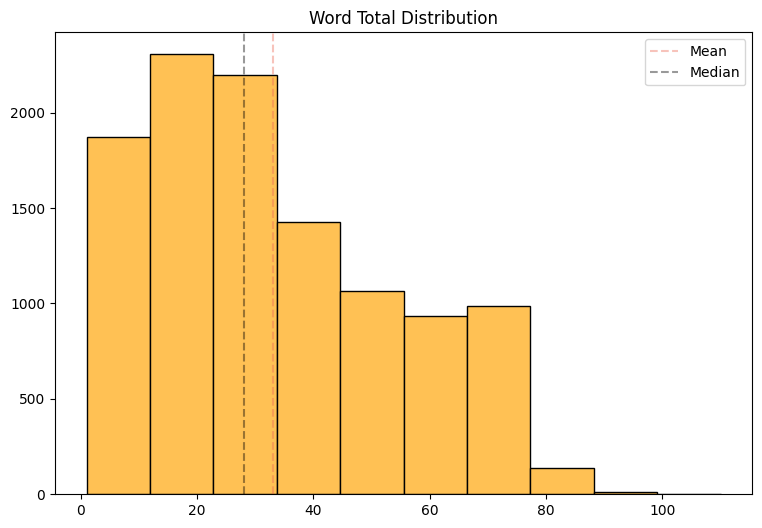

In [12]:
# Distribusi Data

fig = plt.figure(figsize=(9,6))
plt.hist(df['total_kata'], color='#FFC154', edgecolor = 'Black')
plt.axvline(x=df['total_kata'].mean(),ls='--',color='#EC6B56',alpha=0.4,label='Mean')
plt.axvline(x=df['total_kata'].median(),ls='--',color='black',alpha=0.4,label='Median')
plt.title('Word Total Distribution', size=12)
plt.legend()
plt.show()

In [13]:
# Mean and median dari "total_kata"

print('Nilai Mean: {}'.format(df['total_kata'].mean()))
print('Nilai Median: {}'.format(df['total_kata'].median()))

Nilai Mean: 33.060550626543495
Nilai Median: 28.0


### Hasil Eksplorarsi Data Analisis

- Dataset terdiri dari:
    1. label positif sebanyak 6383 (58%)
    2. label negatif sebanyak 3412 (31%)
    3. label neutral sebanyak 1138 (10%)
- Distribusi "total_kata" positive skewness
- Rata-rata dari "total_kata" adalah 33 kata
- Median dari "total_kata" adalah 28 kata

## iii. Text Preprocessing

In [14]:
# Hapus Kolom "total_kata"

df = df.drop('total_kata', axis=1)

In [15]:
def lowercase_function(t):
    return t.lower()

In [16]:
def punctuation_function(t):
    t = re.sub('[^0-9a-zA-Z]+', ' ', t)
    t = re.sub('^rt',' ', t)
    t = re.sub('user',' ', t)
    t = re.sub(' +', ' ', t)
    t = re.sub('\n',' ',t)
    t = re.sub(r'\d+', '', t)
    t = re.sub(r':', ' ', t)    
    t = re.sub(r'pic.twitter.com.[\w]+', ' ', t)
    t = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ', t)
    return t

Selain menggunakan regex library, kita akan mengganti kata yang tidak baku dengan kata yang lebih baku dengan bantuan kamus 'kamusalay' dan RDBMS (SQlite).

In [17]:
# Koneksi Database

conn = sqlite3.connect('database.db')

In [18]:
# Import kamusalay

kamus_alay = pd.read_csv('new_kamusalay.csv',encoding='latin-1',names=['alay','normal'])

# Hubungkan kamusalay kedalam database

kamus_alay.to_sql('kamusalay', conn, if_exists='replace',index=False)
kamus_alay=pd.DataFrame(kamus_alay)
kamus_alay

alay                             normal
0      anakjakartaasikasik           anak jakarta asyik asyik
1             pakcikdahtua                  pak cik sudah tua
2           pakcikmudalagi                  pak cik muda lagi
3              t3tapjokowi                       tetap jokowi
4                       3x                          tiga kali
...                    ...                                ...
15162            mendikbud  menteri pendidikan dan kebudayaan
15163               mendag                menteri perdagangan
15164              menaker               menteri tenaga kerja
15165             memetwit                            mentwit
15166             megangin                           memegang

[15167 rows x 2 columns]

In [19]:
# Mengambil data dari kamusalay

db = sqlite3.connect('D:\dsc_platinum\database.db', check_same_thread = False)
q_kamusalay = 'SELECT * FROM kamusalay'
t_kamusalay = pd.read_sql_query(q_kamusalay, db)

In [20]:
alay_dict = dict(zip(t_kamusalay['alay'], t_kamusalay['normal']))
def alay_to_normal(t):
    for word in alay_dict:
        return ' '.join([alay_dict[word] if word in alay_dict else word for word in t.split(' ')])

In [21]:
# Copy dataset

data = df.copy()
data.head()

Tweet     Label
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1  mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2  lokasi strategis di jalan sumatera bandung . t...  positive
3  betapa bahagia nya diri ini saat unboxing pake...  positive
4  duh . jadi mahasiswa jangan sombong dong . kas...  negative

In [22]:
# Create text cleansing function

def data_cleansing(t):
    t = lowercase_function(t)
    t = punctuation_function(t)
    t = alay_to_normal(t)
    return t

In [23]:
# Menerapkan Function Data Cleansing Kedalam Dataset

data['Tweet'] = data['Tweet'].apply(data_cleansing)
data.head()

Tweet     Label
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1  mohon ulama lurus dan k mmbri hujjah partai ap...   neutral
2  lokasi strategis di jalan sumatra bandung temp...  positive
3  betapa bahagia nya diri ini saat unboxing pake...  positive
4  aduh jadi mahasiswa jangan sombong dong kasih ...  negative

In [24]:
# Old tweet and new tweet comparation

print('Contoh Tweet Lama: {}'.format(df['Tweet'].iloc[154]))
print('\t')
print('Perbaikan Tweet Baru: {}'.format(data['Tweet'].iloc[154]))

Contoh Tweet Lama: menurut sby , yang dipilih dari pilkada adalah sosok bukan partai politik .
	
Perbaikan Tweet Baru: menurut susilo bambang yudhoyono yang dipilih dari pilihan kepala daerah adalah sosok bukan partai politik 


## Data Storing

Dataset yang dibersihkan akan disimpan di database (SQlite).

In [25]:
# Hubungkan data yang dibersihkan ke database

data.to_sql('data', conn, if_exists='replace',index=False)
data=pd.DataFrame(data)
data

Tweet     Label
0      warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1      mohon ulama lurus dan k mmbri hujjah partai ap...   neutral
2      lokasi strategis di jalan sumatra bandung temp...  positive
3      betapa bahagia nya diri ini saat unboxing pake...  positive
4      aduh jadi mahasiswa jangan sombong dong kasih ...  negative
...                                                  ...       ...
10993  f demokrat dorong upaya kemandirian energi nas...   neutral
10994                                        tidak bosan  positive
10996  enak rasa masakan nya apalagi kepiting yang me...  positive
10998  pagi pagi di tol pasteur sudah macet parah bik...  negative
10999  meskipun sering belanja ke yogyakarta di riau ...  positive

[10933 rows x 2 columns]

In [26]:
# Menyimpan Perubahan dan Mengakhiri Database

conn.commit()
conn.close()